In [1]:
import os
import sys

from pathlib import Path

# si aggiunge al path la cartella utils per avere visibilità del modulo
module_path = Path(os.getcwd()).parent.parent
module_path = os.path.join(module_path, "project-detective")

sys.path.append(module_path)

In [2]:
import cv2
import timm
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import utils.semi_hard_mining as shm

from torch import nn
from tqdm import tqdm
from skimage import io
from pathlib import Path
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
# serve per ricaricare automaticamente il codice modificato
%load_ext autoreload
%autoreload 2

In [4]:
# directory da dove vengono prelevate le immagini
path = Path(os.getcwd()).parent.parent
real_data_dir = os.path.join(path, "artifact", "coco")
fake_data_dir = os.path.join(path, "artifact", "taming_transformer")

# per far funzionare il modello su immagini rgb o in scala di grigi (per usare fourier)
mode="rgb"

BATCH_SIZE = 32

LR = 0.001

EPOCHS = 30

DEVICE = "cuda"

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")
print(f"cuDNN version: {torch.backends.cudnn.version()}")
print(f"Available devices: {torch.cuda.device_count()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.3.0+cu121
CUDA version: 12.1
cuDNN version: 8801
Available devices: 1
Device name: NVIDIA GeForce RTX 2050


In [5]:
csv_path = os.path.join("..", "datasets", "super_hard_mining_database.csv")
df = pd.read_csv(csv_path)

df = df.sample(frac=1)

df.head()

train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

print(f"train dataset size: {len(train_df)}")
print(f"val dataset size: {len(valid_df)}")

train dataset size: 47999
val dataset size: 12000


In [6]:
# carica le immagini nel dataset
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    
    if mode == "rgb":
      # le immagini Anchor sono memorizzate in due dataset diversi
      if "tt" in row.Anchor:
        A_img = io.imread(os.path.join(fake_data_dir, row.Anchor))
        P_img = io.imread(os.path.join(fake_data_dir, row.Positive))
        N_img = io.imread(os.path.join(real_data_dir, row.Negative))
      else:
        A_img = io.imread(os.path.join(real_data_dir, row.Anchor))
        P_img = io.imread(os.path.join(real_data_dir, row.Positive))
        N_img = io.imread(os.path.join(fake_data_dir, row.Negative))
          
      # normalizzazione per immagini in rgb 
      A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
      P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
      N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

    if mode == "grey_scale":
      A_img = np.expand_dims(A_img, 0)
      P_img = np.expand_dims(P_img, 0)
      N_img = np.expand_dims(N_img, 0)
      
      A_img = torch.from_numpy(A_img) / 255.0
      P_img = torch.from_numpy(P_img) / 255.0
      N_img = torch.from_numpy(N_img) / 255.0

    # A_img = torch.from_numpy(A_img.astype(np.int32)) / 65536.0
    # P_img = torch.from_numpy(P_img.astype(np.int32)) / 65536.0
    # N_img = torch.from_numpy(N_img.astype(np.int32)) / 65536.0

    return A_img, P_img, N_img

In [7]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)
print(f"trainset size: {len(trainset)}")
print(f"validset size: {len(validset)}")

trainset size: 47999
validset size: 12000


In [8]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [9]:
print(f"#batches in trainloader : {len(trainloader)}")
print(f"#batches in validloader : {len(validloader)}")

#batches in trainloader : 1500
#batches in validloader : 375


In [10]:
# funzione per caricare il modello di rete neurale direttamente dalle repository online
class APN_Model_Pretrained(nn.Module):

  # size del vettore di embedding
  def __init__(self, emb_size = 512):
    super(APN_Model_Pretrained, self).__init__()

    # caricamento del modello, in questo caso efficientnet b0 (architettura più leggera della famiglia)
    self.efficientnet = timm.create_model("tf_efficientnetv2_b0", pretrained=True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [11]:
# funzione per caricare il modello di rete neurale direttamente dalle repository online
class APN_Model(nn.Module):

  # size del vettore di embedding
  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    # caricamento del modello, in questo caso efficientnet b0 (architettura più leggera della famiglia)
    self.efficientnet = timm.create_model("tf_efficientnetv2_b0", pretrained=False)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [12]:
model = APN_Model_Pretrained()

# per processare le immagini in scala di grigi per fare fourier serve una CNN 2D
if mode == "grey_scale":
    model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False)

model.to(DEVICE)

APN_Model_Pretrained(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
      )
      (1): Sequential(
        (0): EdgeResidual(
          (conv_exp): Conv2dSame(16, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (bn1): BatchNormAct2d(
            64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
      

In [13]:
# funzione di train
def train_fn(model, dataloader, optimizer, criterion):
  model.train()
  # on dropout 
  total_loss = 0.0

  for A, P, N in tqdm(dataloader, desc="model training..."):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    # qui vengono creati gli embeddings, le cui distanze verranno calcolate dopo
    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    # criterion è la funzione di loss triplet
    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)


In [14]:
# funzione di evaluation
def eval_fn(model, dataloader, criterion):
  model.eval() 
  # off dropout
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader, desc="model validating..."):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

  return total_loss / len(dataloader)

In [15]:
# triplet loss e adam
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
# training
best_valid_loss = np.Inf

training_epoch_loss = []
validation_epoch_loss = []


for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  training_epoch_loss.append(train_loss)
  validation_epoch_loss.append(valid_loss)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    best_valid_loss = valid_loss
    print("successful weights saving...")

  print(f"epochs: {i+1}, train_loss: {train_loss}, valid_loss: {valid_loss}")

model training...:   0%|          | 0/1500 [00:00<?, ?it/s]C:\Users\acali\anaconda3\envs\fvabdetective\lib\site-packages\timm\layers\conv2d_same.py:27: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(x, weight, bias, stride, (0, 0), dilation, groups)
model validating...: 100%|██████████| 375/375 [03:47<00:00,  1.65it/s]


successful weights saving...
epochs: 1, train_loss: 0.16651310708653183, valid_loss: 0.865044741153717


model validating...: 100%|██████████| 375/375 [03:34<00:00,  1.74it/s]


epochs: 2, train_loss: 0.0928686270515124, valid_loss: 1.2141305135091145


model validating...: 100%|██████████| 375/375 [03:28<00:00,  1.80it/s]


epochs: 3, train_loss: 0.08797720019767681, valid_loss: 1.5173856852849326


model validating...: 100%|██████████| 375/375 [03:35<00:00,  1.74it/s]


epochs: 4, train_loss: 0.07301291224981347, valid_loss: 1.259979066848755


model validating...: 100%|██████████| 375/375 [03:42<00:00,  1.68it/s]


epochs: 5, train_loss: 0.06179644792775313, valid_loss: 1.105218960762024


model validating...: 100%|██████████| 375/375 [03:33<00:00,  1.75it/s]


epochs: 6, train_loss: 0.04204802798728148, valid_loss: 1.3658646241823833


model validating...: 100%|██████████| 375/375 [03:09<00:00,  1.98it/s]


epochs: 7, train_loss: 0.055911550105238954, valid_loss: 1.1807018601497015


model validating...: 100%|██████████| 375/375 [03:01<00:00,  2.07it/s]


epochs: 8, train_loss: 0.03966478125751018, valid_loss: 1.2750443127950033


model validating...: 100%|██████████| 375/375 [03:20<00:00,  1.87it/s]


epochs: 9, train_loss: 0.03330941420296828, valid_loss: 1.1326056111653646


model validating...: 100%|██████████| 375/375 [03:03<00:00,  2.04it/s]


epochs: 10, train_loss: 0.033144711340467134, valid_loss: 1.210031717936198


model validating...: 100%|██████████| 375/375 [03:26<00:00,  1.82it/s]


epochs: 11, train_loss: 0.02239693563679854, valid_loss: 1.262884677886963


model validating...: 100%|██████████| 375/375 [03:22<00:00,  1.85it/s]


epochs: 12, train_loss: 0.02798969768981139, valid_loss: 1.2999174229303996


model validating...: 100%|██████████| 375/375 [03:30<00:00,  1.78it/s]


epochs: 13, train_loss: 0.027527745246887208, valid_loss: 1.1096739358901977


model validating...: 100%|██████████| 375/375 [03:30<00:00,  1.78it/s]


epochs: 14, train_loss: 0.029161125361919404, valid_loss: 1.8030705297787983


model validating...: 100%|██████████| 375/375 [03:15<00:00,  1.92it/s]


epochs: 15, train_loss: 0.026488177900513013, valid_loss: 1.1250533992449443


model validating...: 100%|██████████| 375/375 [03:21<00:00,  1.86it/s]


epochs: 16, train_loss: 0.020364052563905714, valid_loss: 1.2310251207351686


model validating...: 100%|██████████| 375/375 [03:15<00:00,  1.92it/s]


epochs: 17, train_loss: 0.02825231661895911, valid_loss: 1.1652188536326091


model validating...: 100%|██████████| 375/375 [03:28<00:00,  1.80it/s]


epochs: 18, train_loss: 0.01762602985401948, valid_loss: 0.9973865509033203


model validating...: 100%|██████████| 375/375 [03:55<00:00,  1.59it/s]


epochs: 19, train_loss: 0.018538034439086915, valid_loss: 0.9552630083560943


model validating...: 100%|██████████| 375/375 [03:48<00:00,  1.64it/s]


epochs: 20, train_loss: 0.02024073365330696, valid_loss: 1.3788236961364746


model validating...: 100%|██████████| 375/375 [03:31<00:00,  1.77it/s]


epochs: 21, train_loss: 0.017675763234496118, valid_loss: 1.0815543953577678


model validating...: 100%|██████████| 375/375 [03:06<00:00,  2.01it/s]


epochs: 22, train_loss: 0.013110866462190946, valid_loss: 1.0928807776769003


model validating...: 100%|██████████| 375/375 [03:02<00:00,  2.05it/s]


epochs: 23, train_loss: 0.021526952768365543, valid_loss: 1.2398708177407582


model validating...: 100%|██████████| 375/375 [03:23<00:00,  1.84it/s]


epochs: 24, train_loss: 0.01177259277800719, valid_loss: 1.5271867079734802


model validating...: 100%|██████████| 375/375 [03:07<00:00,  2.00it/s]


epochs: 25, train_loss: 0.014816812535127004, valid_loss: 1.2998120489120484


model validating...: 100%|██████████| 375/375 [03:12<00:00,  1.95it/s]


epochs: 26, train_loss: 0.014892839699983597, valid_loss: 1.1721062019666035


model validating...: 100%|██████████| 375/375 [03:11<00:00,  1.96it/s]


epochs: 27, train_loss: 0.021942397102713587, valid_loss: 1.0466995865503947


model validating...: 100%|██████████| 375/375 [03:06<00:00,  2.01it/s]


epochs: 28, train_loss: 0.012503138745824496, valid_loss: 1.4304863899548848


model validating...: 100%|██████████| 375/375 [03:03<00:00,  2.04it/s]


epochs: 29, train_loss: 0.011977529949663827, valid_loss: 1.309693442026774


model validating...: 100%|██████████| 375/375 [03:28<00:00,  1.80it/s]

epochs: 30, train_loss: 0.013530222728848457, valid_loss: 1.5326835463841757


<function matplotlib.pyplot.show(close=None, block=None)>

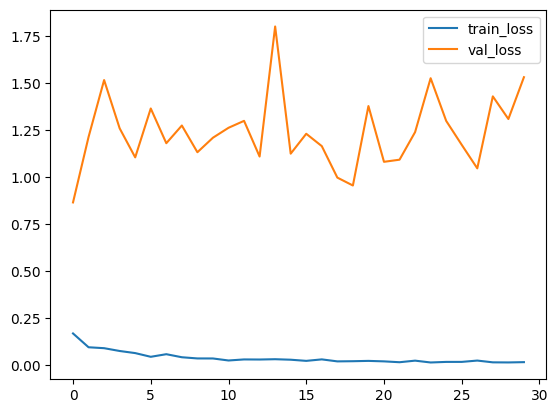

In [27]:
# plot della training e validation loss
plt.plot(training_epoch_loss, label="train_loss")
plt.plot(validation_epoch_loss, label="val_loss")
plt.legend()

plt.show

In [ ]:
# funzione per generare i vettori di encoding
def get_encoding_csv(model, anc_img_names, dirFolder):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()

  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):

      if mode == "rgb":
        # serve per trovare correttamente l'immagine
        if "tt" in i:
          dirFolder = fake_data_dir
          A = io.imread(os.path.join(dirFolder,i))
        else: 
          dirFolder = real_data_dir
          A = io.imread(os.path.join(dirFolder,i))

        A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      
      if mode == "grey_scale":
        A = io.imread(os.path.join(dirFolder,i))

        A = np.expand_dims(A, 0)
        A = torch.from_numpy(A.astype(np.int32)) / 255.0
        
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

    return df_enc

In [ ]:
# per ricaricare il modello una volta allenato
model.load_state_dict(torch.load("best_model.pt"))

# si creano gli embeddings che vengono memorizzati per non rifarlo ad ogni allenamento
df_enc = get_encoding_csv(model, df["Anchor"], real_data_dir)

df_enc.to_csv("database.csv", index=False)

100%|██████████| 59999/59999 [26:06<00:00, 38.30it/s]


In [ ]:
df_enc = pd.read_csv('database.csv')
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,tt-cc/cin_k600_p1.0_a0.05_fid5.20/598/img02774...,-0.124658,-0.091431,0.050611,0.679447,-0.245697,0.229582,-0.846897,-0.406674,0.107818,...,0.043339,-0.448163,-0.158672,0.654229,-0.396956,-0.171089,-0.355457,-0.469718,0.024145,-0.228178
1,coco/coco2017/test2017/img006854.jpg,0.383655,-0.050180,0.406125,0.463091,-0.614331,0.040765,-0.095143,-0.514846,0.061576,...,0.168750,-0.280504,-0.394734,0.246051,-0.295070,-0.271180,-0.018073,-0.430399,-0.286653,0.049347
2,tt-cc/cin_k600_p1.0_a0.05_fid5.20/32/img012325...,-0.012184,0.014519,0.266759,0.580086,-0.321256,0.234037,-0.595014,-0.504946,-0.019622,...,-0.006954,-0.283297,-0.142755,0.535688,-0.221544,-0.140319,-0.257174,-0.387291,-0.004347,-0.256935
3,coco/coco2017/train2017/img058920.jpg,0.409047,0.058612,0.288157,0.540761,-0.496664,0.404197,-0.385226,-0.327541,0.010293,...,-0.086431,-0.415242,-0.609149,0.542471,-0.197580,-0.053091,0.076732,-0.355684,-0.131601,-0.229301
4,tt-cc/cin_k600_p1.0_a0.05_fid5.20/422/img01804...,0.179404,0.093132,0.387256,0.334306,-0.338582,0.131990,-0.382386,-0.520698,0.105204,...,0.040855,-0.287094,-0.336185,0.375461,-0.140042,-0.032378,0.043848,-0.299050,-0.174029,-0.370719


In [ ]:
# approssimazione della distanza, senza la radice quadrata, per fare i primi allenamenti velocemente
def euclidean_dist(img_enc, anc_enc_arr):
    # dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T))
    dist = np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T)
    # dist = np.sqrt(dist)
    return dist

In [ ]:
path = os.path.join(Path(os.getcwd()).parent, "datasets", "testList.csv")
df = pd.read_csv(path)

print(df["real"])
print(df.size)
df.head()

0        coco/coco2017/train2017/img102692.jpg
1        coco/coco2017/train2017/img059219.jpg
2         coco/coco2017/test2017/img036374.jpg
3         coco/coco2017/test2017/img010933.jpg
4        coco/coco2017/train2017/img153404.jpg
                         ...                  
11994    coco/coco2017/train2017/img043171.jpg
11995     coco/coco2017/test2017/img007453.jpg
11996    coco/coco2017/train2017/img121362.jpg
11997    coco/coco2017/train2017/img084676.jpg
11998    coco/coco2017/train2017/img150021.jpg
Name: real, Length: 11999, dtype: object
23998


,real,fake
0,coco/coco2017/train2017/img102692.jpg,tt-ffhq/ffhq_k300_p1.0_fid9.6/img020063.jpg
1,coco/coco2017/train2017/img059219.jpg,tt-ffhq/ffhq_k300_p1.0_fid9.6/img001432.jpg
2,coco/coco2017/test2017/img036374.jpg,tt-cc/cin_k600_p1.0_a0.05_fid5.20/797/img03876...
3,coco/coco2017/test2017/img010933.jpg,tt-ffhq/ffhq_k300_p1.0_fid9.6/img037317.jpg
4,coco/coco2017/train2017/img153404.jpg,tt-ffhq/ffhq_k300_p1.0_fid9.6/img013385.jpg


In [ ]:
def getImageEmbeddings(img, model):
    if mode == "rgb":
        img = torch.from_numpy(img).permute(2, 0, 1) / 255.0
      
    if mode == "grey_scale":
        img = np.expand_dims(img, 0)
        img = torch.from_numpy(img) / 255
    
    model.eval()
    with torch.no_grad():
        img = img.to(DEVICE)
        img_enc = model(img.unsqueeze(0))
        img_enc = img_enc.detach().cpu().numpy()
        img_enc = np.array(img_enc)

    return img_enc

In [ ]:
def searchInDatabase(img_enc, database):
    anc_enc_arr = database.iloc[:, 1:].to_numpy()
    anc_img_names = database["Anchor"]

    distance = []
    for i in range(anc_enc_arr.shape[0]):
        dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
        distance = np.append(distance, dist)

    closest_idx = np.argsort(distance)

    return database["Anchor"][closest_idx[0]]

In [29]:
# DataTestReal = 'C:/Users/polsi/Desktop/Lavori/DeepFake/Datasets/Artifact/cycle_gan/st/test/'
path = Path(os.getcwd()).parent.parent
real_data_dir = os.path.join(path, "artifact", "coco")
fake_data_dir = os.path.join(path, "artifact", "taming_transformer")

y_true = []
y_pred = []

tempDf = df
tempDf.head()
tempDf.shape

(11999, 2)

In [30]:
# testo i fake
currentTest = "fake"
database = df_enc

# prendo i primi 500 Fake
for index, row in tqdm(tempDf.iterrows(), desc="testing on fake images..."):
    path = os.path.join(fake_data_dir, row[currentTest])
    img_name = path

    img = io.imread(img_name)

    img_enc = getImageEmbeddings(img, model)

    closestLabel = searchInDatabase(img_enc, database)

    if mode == "rgb":
        if str(closestLabel).startswith("tt"):
            y_pred.append("fake")
        else:
            y_pred.append("real")

    if mode == "grey_scale": 
        if "coco" in closestLabel:
            y_pred.append("real")
        else:
            y_pred.append("fake")

testing on fake images...: 11999it [2:55:09,  1.14it/s]


In [31]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

0
11999
['real', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'fake',

In [32]:
# testo i real
currentTest = "real"
database = df_enc

# prendo i primi 500 Fake
for index, row in tqdm(tempDf.iterrows(), desc="testing on real images..."):
    path = os.path.join(real_data_dir, row[currentTest])
    img_name = path

    img = io.imread(img_name)

    img_enc = getImageEmbeddings(img, model)

    closestLabel = searchInDatabase(img_enc, database)
    
    if mode == "rgb":
        if "tt" in closestLabel:
            y_pred.append("fake")
            
        else:
            y_pred.append("real")

    if mode == "grey_scale": 
        if "real" in closestLabel:
            y_pred.append("real")
        else:
            y_pred.append("fake")


testing on real images...: 11999it [2:51:21,  1.17it/s]


In [33]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

0
23998
['real', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'fake',

In [46]:
# creo i vettori di ground truth
y_true = np.array(["fake"] * 11999)
print(y_true.shape)

temp = np.array(["real"] * 11999)
print(temp.shape)

y_true = np.concatenate([y_true, temp])
print(y_true.shape)

# calcolo la matrice di confusione (quella di scikit-learn dispone i risultati come nella cella di sotto)
cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
print(cm)

(11999,)
(11999,)
(23998,)
[[6007 5992]
 [6090 5909]]


In [47]:
TN, FP, FN, TP = cm.ravel()

# metriche
accuracy = round((TP + TN) / (TP + TN + FP + FN), 4) * 100
precision = round((TP) / (TP + FP), 4) * 100
recall = round((TP) / (TP + FN), 4) * 100
specificity = round((TN) / (TN + FP) * 100, 4)
f1_score = round((2 * precision * recall) / (precision + recall), 4)

print({"Accuracy":accuracy, "Precision":precision, "Recall":recall, "Specificity":specificity, "F1 Score":f1_score})

{'Accuracy': 49.65, 'Precision': 49.65, 'Recall': 49.25, 'Specificity': 50.0625, 'F1 Score': 49.4492}


In [48]:
# si salvano i risultati in un file .csv
df_results = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "Specificity", "F1 Score"])
df_results.loc[0] = [accuracy, precision, recall, specificity, f1_score]

# si differenziano i risultati in base al tipo di immagini e dataset usati
dataset = fake_data_dir.split("\\")[-1]
path = os.path.join("..", "results", "siamese_" + mode + "_" + dataset + "_results.csv")

df_results.to_csv(path, index=False)